# Cross-Encoder Fine-Tuning

This notebook fine-tunes the Cross-Encoder model (`ms-marco-MiniLM-L-6-v2`) using the training data generated in the previous step.

We use **5-Fold Cross-Validation** to ensure robust evaluation and prevent data leakage (grouped by video).

In [ ]:
import pandas as pd
import numpy as np
from sentence_transformers import CrossEncoder, InputExample
from torch.utils.data import DataLoader
import torch
import os
import sys
from pathlib import Path
from shutil import make_archive

MODEL_NAME = 'cross-encoder/ms-marco-MiniLM-L-6-v2'
NUM_EPOCHS = 4
BATCH_SIZE = 32
LEARNING_RATE = 2e-5


DATA_PATH = BASE_DIR / 'data' / 'training' / 'train_data_5folds.csv'
OUTPUT_DIR = BASE_DIR / 'results' / 'models'
PREDICTIONS_DIR = BASE_DIR / 'results' / 'predictions'

# Create directories
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
PREDICTIONS_DIR.mkdir(parents=True, exist_ok=True)

print(f"Current Working Directory: {current_dir}")
print(f"Data Path: {DATA_PATH}")
print(f"Output Dir: {OUTPUT_DIR}")

In [ ]:

    from google.colab import drive
    try:
        drive.mount('/content/drive', force_remount=True) # force_remount
        print("Google Drive mounted successfully!")
    except Exception as e:
        print(f" Error mounting Google Drive: {e}")
        print("authorize Google Drive access when prompted.")
        raise

    import shutil
    import os
    target_data_dir = '/content/data/training'
    os.makedirs(target_data_dir, exist_ok=True)

    source_path_in_drive = '/content/drive/MyDrive/train_data_5folds.csv'
    destination_path = f'{target_data_dir}/train_data_5folds.csv'

    print(f"\n Attempting to copy data from '{source_path_in_drive}' to '{destination_path}'...")
    if os.path.exists(source_path_in_drive):
        try:
            shutil.copy(source_path_in_drive, destination_path)
            print(f" Data '{os.path.basename(source_path_in_drive)}' copied successfully!")
        except Exception as e:
            print(f" Error copying data file: {e}")
            print(f"Please ensure '{source_path_in_drive}' exists in your Google Drive.")
            raise FileNotFoundError(f"Data file not found or could not be copied from Google Drive: {source_path_in_drive}")
    else:
        print(f" Warning: '{source_path_in_drive}' not found in Google Drive. Please ensure the file is placed correctly or update the source path in the notebook.")
        raise FileNotFoundError(f"Data file not found in Google Drive: {source_path_in_drive}")



In [ ]:


df = pd.read_csv(DATA_PATH)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Training on: {device}")
print(f"Loaded {len(df)} samples")
df.head()

Loading data...
Training on: cuda
Loaded 12170 samples


,video_id,chunk_id,skill_id,query_text,text,label,fold,is_hard_negative
0,0B5eIE_1vpU,80,sklearn_model_training,Scikit-learn model training: Learn to train ma...,a subsection over here under more where it rea...,0.2125,1,True
1,-cuhXbg8UBI,0,numpy_array_manipulation,"NumPy array manipulation: Learn how to create,...",music hello everyone in this video i want to t...,0.4375,1,False
2,-cuhXbg8UBI,1,numpy_array_manipulation,"NumPy array manipulation: Learn how to create,...",not a pin and then we'll append each element w...,0.7375,1,False
3,-cuhXbg8UBI,2,numpy_array_manipulation,"NumPy array manipulation: Learn how to create,...",well so mp and square root eight executing all...,0.6000,1,False
4,-IvNzmrcyUM,0,sklearn_model_training,Scikit-learn model training: Learn to train ma...,hello everyone and welcome to the best machine...,0.3125,2,True


In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"
os.environ["HF_HUB_DISABLE_PROGRESS_BARS"] = "1"


all_predictions = []

for fold in range(5):
    print(f"\n=== STARTING FOLD {fold}/4 ===")

    # Split Data
    train_df = df[df['fold'] != fold]
    test_df = df[df['fold'] == fold]

    print(f"Train size: {len(train_df)}, Test size: {len(test_df)}")

    # Create Training Examples
    train_examples = []
    for _, row in train_df.iterrows():
        train_examples.append(InputExample(
            texts=[row['query_text'], row['text']],
            label=float(row['label'])
        ))

    # Create DataLoader
    train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=BATCH_SIZE)

    # Initialize Model
    model = CrossEncoder(MODEL_NAME, num_labels=1, max_length=512, device=device)

    # Train
    warmup_steps = int(len(train_dataloader) * NUM_EPOCHS * 0.1)

    model.fit(
        train_dataloader=train_dataloader,
        epochs=NUM_EPOCHS,
        warmup_steps=warmup_steps,
        optimizer_params={'lr': LEARNING_RATE},
        show_progress_bar=True
    )

    # Save Model (Only saving Fold 0 to keep disk usage low, but training all 5)
    if fold == 0:
        save_path = f"{OUTPUT_DIR}/best_model_fold0"
        model.save(str(save_path))
        print(f"Saved Fold 0 model to {save_path}")

    # Predict on Held-Out Fold
    print(f"Generating predictions for Fold {fold}...")
    test_inputs = test_df[['query_text', 'text']].values.tolist()

    # Run Inference
    pred_scores = model.predict(test_inputs, batch_size=64, show_progress_bar=True)

    # Store Results
    fold_results = test_df[['video_id', 'chunk_id', 'skill_id']].copy()
    fold_results['score'] = pred_scores
    fold_results['fold'] = fold
    all_predictions.append(fold_results)


In [ ]:
#  Save Final Results
final_preds = pd.concat(all_predictions)
output_file = PREDICTIONS_DIR / 'cross_encoder_finetuned_predictions.csv'
final_preds.to_csv(output_file, index=False)
print(f"Done! Predictions saved to {output_file}")

In [ ]:
# Archive Model
# Zip
archive_name = OUTPUT_DIR / 'best_model_fold0'
make_archive(str(archive_name), 'zip', root_dir=OUTPUT_DIR / 'best_model_fold0')
print(f" Model archived to {archive_name}.zip")

Generating distribution plot for prediction scores...


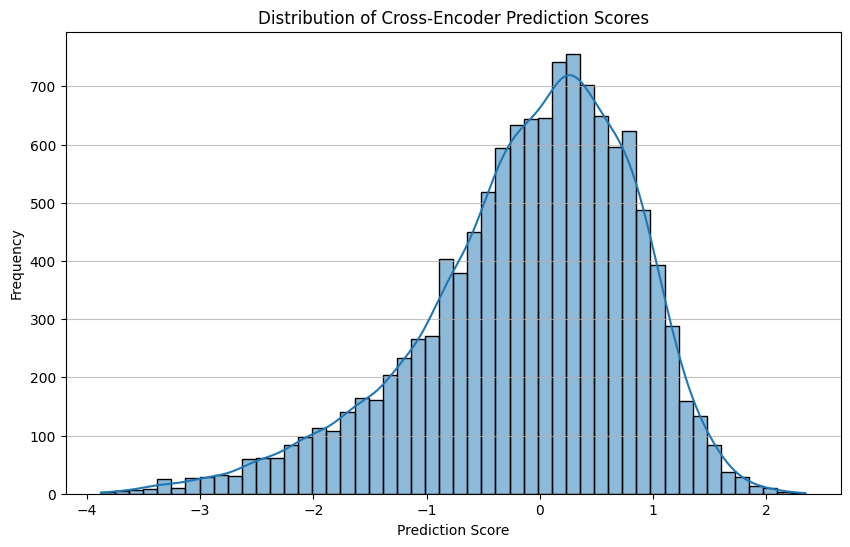


This plot shows the distribution of the scores predicted by the fine-tuned Cross-Encoder model across all folds.
The scores typically range from negative to positive, with higher scores indicating a stronger semantic similarity between the query and the text.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

print("Generating distribution plot for prediction scores...")

plt.figure(figsize=(10, 6))
sns.histplot(final_preds['score'], bins=50, kde=True)
plt.title('Distribution of Cross-Encoder Prediction Scores')
plt.xlabel('Prediction Score')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

print("\nThis plot shows the distribution of the scores predicted by the fine-tuned Cross-Encoder model across all folds.")
print("The scores typically range from negative to positive, with higher scores indicating a stronger semantic similarity between the query and the text.")